In [124]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Question: How can the system be cured a 100% in a reasonable time?

### Curing of epoxy.

The probability of bonding ($p$) is currently controlled by the activation energy ($E_a$) as an Arrhenius function 

$ p(\chi,k_BT,E_a) = \frac{exp\Big(\frac{-E_a}{k_BT}\Big)}{w(\chi)}$

where $\chi$ is the bond rank and $w$ is the weight defined as :

$w = 1$    if   $\chi =0$

$w = 500$  if   $\chi >0$

In order to estimate an appropriate activation energy for a range of temperatures (0.1, 1, 2, 4, 6) kT, $p$ is plotted as a function of $E_a$ for these temperatures. Here an "appropriate" $E_a$ should yield considerabily different values of $p$ between the maximum and minimum temperatures considered.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


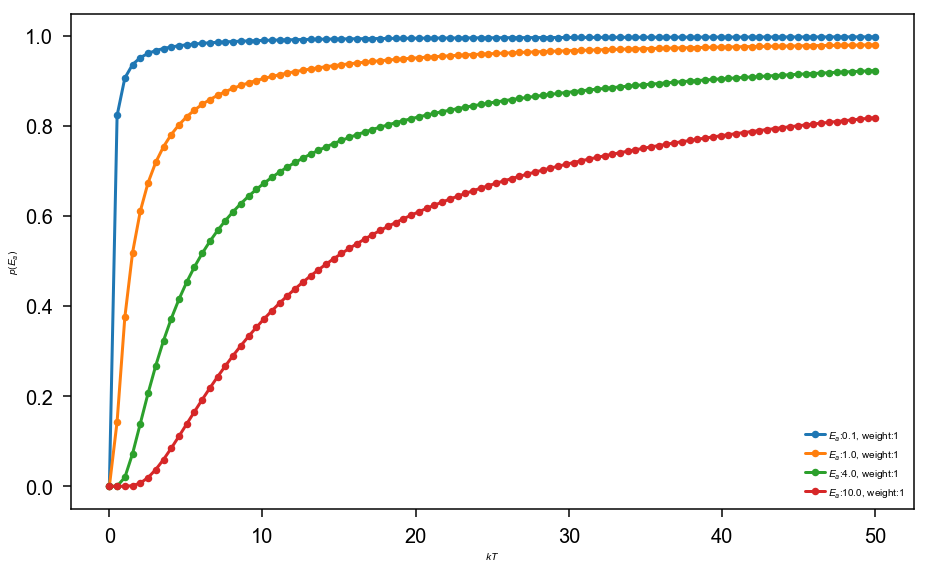

In [172]:
import numpy as np
kTs = np.linspace(0.01,50,100)
weights = [1]
delta_es = [0.1,1.0,4.0,10.0]#np.linspace(0.001,5,50)

plt.figure(figsize=(13,8))
for w in weights:
    for delta_e in delta_es:
        mb_stats = []
        for kT in kTs:
            mb_stat = np.exp(-delta_e / kT)
            mb_stats.append(mb_stat/w)
        label = '$E_a$:{}, weight:{}'.format(delta_e,w)
        plt.plot(kTs,mb_stats,marker='o',label=label)
plt.legend()
plt.xlabel('$kT$')
plt.ylabel('$p(E_a)$')
plt.tight_layout()
plt.show()

* High $E_a$ leads to a zero probability for the range of temperatures here and low $E_a$ results in no difference in probability wrt to temperature.
* $E_a$ of 1.0 appears to yield a reasonable gradient in the probabilities for temperatures 0 to 30 kT

[ 0.001       0.10302041  0.20504082  0.30706122  0.40908163]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


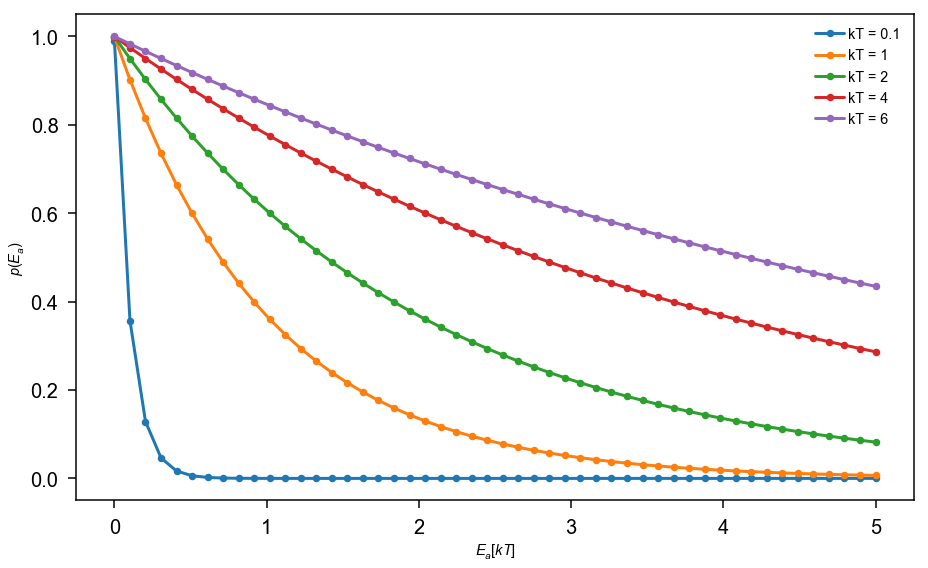

In [2]:
import numpy as np
kTs = [0.1,1,2,4,6]
delta_es = np.linspace(0.001,5,50)
print(delta_es[:5])
plt.figure(figsize=(13,8))
for kT in kTs:
    mb_stats = []
    for delta_e in delta_es:
        mb_stat = np.exp(-delta_e / kT)
        mb_stats.append(mb_stat)
    label = 'kT = {}'.format(kT)
    plt.plot(delta_es,mb_stats,marker='o',label=label)
plt.legend()
plt.xlabel('$E_a [kT]$')
plt.ylabel('$p(E_a)$')
plt.show()

From the above plot, an activation energy of 1.0 gives appreciable difference in bonding probability and should produce significant difference in cure percentages for the range of temperatures we are interested in (0.1,1,2,4,6,20).

### Now that we have an idea about probabilities, let try to emulate the bonding using $E_a$ of 1.0

* We need a way to emulate the bonding without running MD to understand the theoretical limit of the curing.
* In order to do that we use the same number of particles as in the MD simulation and randomly pick the particles and attempt to bond with complimentary particles.
* Here we assume that the particles have infinite diffusivity, i.e. if there is a particle available for bonding, it will eventually find a complimentary particle and bond.
* At each timestep we attempt to bond with 6 other particles.

In [115]:
import numpy as np
from epoxpy.bonding import Bonding, FreudBonding
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import random


def bond_test(kT, delta_e, bond_rank, sec_bond_weight=500):
    weight = 1
    if bond_rank >= 1:
        weight = sec_bond_weight
    mb_stats = np.exp(-delta_e*weight / kT)
    if mb_stats > random.random():
        return True
    else:
        return False
        
def plot_bonding(kTs,activation_energy,no_weights=False,weight=500, time=5000000,show_all=True,y_lim=100,
                 show_figure=True, legend=None,weighting_scheme2=False):
    if show_figure:
        plt.figure(figsize=(15,10))

    for kT in kTs:
        
        bond_steps = []
        log_steps = []
        bond_percents = []
        zero_br = []
        one_br = []
        two_br = []
        three_br = []
        four_br = []
        n_mul = 10000
        num_a = 1*n_mul
        num_b = 2*n_mul
        tot_particles = num_a+num_b
        #print(tot_particles)
        n_bonds = 0
        a = np.array([0]*num_a + [1]*num_b)
        #np.random.shuffle(a)
        #print(a)
        rank_dict = {}
        get_rank = rank_dict.get
        possible_bonds = ((num_a * FreudBonding.MAX_A_BONDS) / 2) + ((num_b * FreudBonding.MAX_B_BONDS) / 2)
        #print('possible_bonds: ', possible_bonds)
        for ts in np.arange(0,time,1):
            if ts% 10 == 0:# try bonding every 10 steps
                bond_from_idx = random.randint(0,tot_particles-1)# pick a particle to bond
                bond_from_type = a[bond_from_idx]
                bond_from_rank = get_rank(bond_from_idx, -1)# get bond rank of particle to bond from
                if bond_from_type == 0:
                    max_rank = FreudBonding.MAX_A_BONDS
                    bond_to_type = 1
                    max_bond_to_rank = FreudBonding.MAX_B_BONDS
                else:
                    max_rank = FreudBonding.MAX_B_BONDS
                    bond_to_type = 0
                    max_bond_to_rank = FreudBonding.MAX_A_BONDS
                if bond_from_rank < max_rank:# if rank is less than maximum rank try bonding
                    made_bond = False
                    trials = 0
                    while trials<6:# try bonding with 6 neighbours which are assumed to be in the viscinity
                        temp_bond_to = bond_from_type
                        while temp_bond_to == bond_from_type:# loop till a complimentary particle is found for bonding
                            bond_to_idx = random.randint(0,tot_particles-1)
                            temp_bond_to = a[bond_to_idx]
                        
                        bond_to_rank = get_rank(bond_to_idx, -1)
                        if bond_to_rank < max_bond_to_rank:# check if the complementary particle is ready to be bonded
                            if no_weights:
                                br = 0
                            else:
                                br = bond_to_rank
                                
                            if weighting_scheme2:
                                made_bond = bond_test(kT=kT,delta_e = activation_energy, bond_rank=br, sec_bond_weight=weight)#bond_to_rank)
                            else:
                                made_bond = Bonding.bond_test(kT=kT,delta_e = activation_energy, bond_rank=br, sec_bond_weight=weight)#bond_to_rank)
                            
                            if made_bond:
                                n_bonds += 1
                                if bond_from_rank == -1:
                                    rank_dict[bond_from_idx] = 0
                                if bond_to_rank == -1:
                                    rank_dict[bond_to_idx] = 0
                                rank_dict[bond_from_idx] += 1
                                rank_dict[bond_to_idx] += 1
                        if made_bond:
                            break
                        trials += 1
    
                bond_percent = (n_bonds / possible_bonds) * 100.
                bond_steps.append(ts)
                bond_percents.append(bond_percent)
                
            if ts% 1000 == 0:# try logging every 1000 steps
                dic_vals = rank_dict.values()
                keys = (list(Counter(dic_vals).keys()))
                values = (list(Counter(dic_vals).values()))
                row = np.zeros(4)
                #print('row ',row)
                for i in range(0,4):
                    #print(i)
                    if i+1 in keys:
                        row[i] = values[keys.index(i+1)]
                row = [row]
                this_row = row[0]
                tot_one = (this_row[0]*1)/2
                tot_two = (this_row[1]*2)/2
                tot_three = (this_row[2]*3)/2
                tot_four = (this_row[3]*4)/2
                tot = (tot_one+tot_two+tot_three+tot_four)
                tot_zero = possible_bonds - tot
                zero_br.append((tot_zero/possible_bonds)*100.)
                one_br.append((tot_one/possible_bonds)*100.)
                two_br.append((tot_two/possible_bonds)*100.)
                three_br.append((tot_three/possible_bonds)*100.)
                four_br.append((tot_four/possible_bonds)*100.)
                log_steps.append(ts)
                
            if bond_percent >= 100.0:
                break    
        if legend is None:
            legend = '{} kT'.format(kT)
        plt.plot(bond_steps,bond_percents, label=legend)
        if show_all:
            #plt.plot(log_steps,zero_br, label='bond rank = 0')
            plt.plot(log_steps,one_br, label='bond rank = 1')
            plt.plot(log_steps,two_br, label='bond rank = 2')
            plt.plot(log_steps,three_br, label='bond rank = 3')
            plt.plot(log_steps,four_br, label='bond rank = 4')
        print('kT ',kT,' bond_percent ',bond_percent,' time step ',ts)
    plt.xlabel('Time steps')
    plt.ylabel('Curing percent')
    plt.ylim(0,y_lim)
    plt.legend()
    if show_figure:
        plt.show()

def plot_bonding_degree(kTs,activation_energy,no_weights=False,weight=500, time=5000000,show_all=True,y_lim=100,
                 show_figure=True, legend=None,weighting_scheme2=False,n_mul=10000):
    if show_figure:
        plt.figure(figsize=(15,10))

    for kT in kTs:
        
        bond_steps = []
        log_steps = []
        bond_percents = []
        primary_bonds = []
        secondary_bonds = []
        ternary_bonds = []
        quatenary_bonds = []
        num_a = 1*n_mul
        num_b = 2*n_mul
        tot_particles = num_a+num_b
        #print(tot_particles)
        n_bonds = 0
        a = np.array([0]*num_a + [1]*num_b)
        #np.random.shuffle(a)
        #print(a)
        rank_dict = {}
        a_bond_degrees = {}
        get_rank = rank_dict.get
        get_a_bond_degree = a_bond_degrees.get
        possible_bonds = ((num_a * FreudBonding.MAX_A_BONDS) / 2) + ((num_b * FreudBonding.MAX_B_BONDS) / 2)
        #print('possible_bonds: ', possible_bonds)
        for ts in np.arange(0,time,1):
            if ts% 10 == 0:# try bonding every 10 steps
                bond_from_idx = random.randint(0,tot_particles-1)# pick a particle to bond
                bond_from_type = a[bond_from_idx]
                bond_from_rank = get_rank(bond_from_idx, 0)# get bond rank of particle to bond from
                if bond_from_type == 0:
                    max_rank = FreudBonding.MAX_A_BONDS
                    bond_to_type = 1
                    max_bond_to_rank = FreudBonding.MAX_B_BONDS
                else:
                    max_rank = FreudBonding.MAX_B_BONDS
                    bond_to_type = 0
                    max_bond_to_rank = FreudBonding.MAX_A_BONDS
                if bond_from_rank < max_rank:# if rank is less than maximum rank try bonding
                    made_bond = False
                    trials = 0
                    while trials<6:# try bonding with 6 neighbours which are assumed to be in the viscinity
                        temp_bond_to = bond_from_type
                        while temp_bond_to == bond_from_type:# loop till a complimentary particle is found for bonding
                            bond_to_idx = random.randint(0,tot_particles-1)
                            temp_bond_to = a[bond_to_idx]
                        
                        bond_to_rank = get_rank(bond_to_idx, 0)
                        if bond_to_rank < max_bond_to_rank:# check if the complementary particle is ready to be bonded
                            if no_weights:
                                br = 0
                            else:
                                br = bond_to_rank
                                
                            if weighting_scheme2:
                                made_bond = bond_test(kT=kT,delta_e = activation_energy, bond_rank=br, sec_bond_weight=weight)#bond_to_rank)
                            else:
                                made_bond = Bonding.bond_test(kT=kT,delta_e = activation_energy, bond_rank=br, sec_bond_weight=weight)#bond_to_rank)
                            
                            if made_bond:
                                n_bonds += 1
                                if bond_from_rank == 0:
                                    rank_dict[bond_from_idx] = 0
                                if bond_to_rank == 0:
                                    rank_dict[bond_to_idx] = 0
                                rank_dict[bond_from_idx] += 1
                                rank_dict[bond_to_idx] += 1
                                if bond_from_type == 0:
                                    previous_rank = bond_from_rank
                                    new_rank = bond_from_rank+1
                                    if get_a_bond_degree(new_rank,0) == 0:
                                        a_bond_degrees[new_rank] = 0
                                    a_bond_degrees[new_rank] += 1
                                    if previous_rank > 0:
                                        a_bond_degrees[previous_rank] += -1
                                else:
                                    previous_rank = bond_to_rank
                                    new_rank = bond_to_rank+1
                                    if get_a_bond_degree(new_rank,0) == 0:
                                        a_bond_degrees[new_rank] = 0
                                    a_bond_degrees[new_rank] += 1
                                    if previous_rank > 0:
                                        a_bond_degrees[previous_rank] += -1
                        if made_bond:
                            break
                        trials += 1
    
                bond_percent = (n_bonds / possible_bonds) * 100.
                bond_steps.append(ts)
                bond_percents.append(bond_percent)
               
            #print(rank_dict)
            if ts% 1000 == 0:# try logging every 1000 steps
                #zero_br.append((tot_zero/possible_bonds)*100.)
                p_bonds = get_a_bond_degree(1,0)
                s_bonds = get_a_bond_degree(2,0)
                t_bonds = get_a_bond_degree(3,0)
                q_bonds = get_a_bond_degree(4,0)
                primary_bonds.append((p_bonds/num_a)*100.)
                secondary_bonds.append((s_bonds/num_a)*100.)
                ternary_bonds.append((t_bonds/num_a)*100.)
                quatenary_bonds.append((q_bonds/num_a)*100.)
                log_steps.append(ts)
                
            if bond_percent >= 100.0:
                break    
        if legend is None:
            legend = '{} kT'.format(kT)
        plt.plot(bond_steps,bond_percents, label=legend)
        if show_all:
            #plt.plot(log_steps,zero_br, label='bond rank = 0')
            plt.plot(log_steps,primary_bonds, label='primary amines')
            plt.plot(log_steps,secondary_bonds, label='secondary amines')
            plt.plot(log_steps,ternary_bonds, label='ternary amines')
            plt.plot(log_steps,quatenary_bonds, label='quaternary amines')
        print('kT ',kT,' bond_percent ',bond_percent,' time step ',ts)
    plt.xlabel('Time steps')
    plt.ylabel('Curing percent')
    plt.ylim(0,y_lim)
    plt.legend()
    if show_figure:
        plt.show()

kT  30  bond_percent  99.665  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


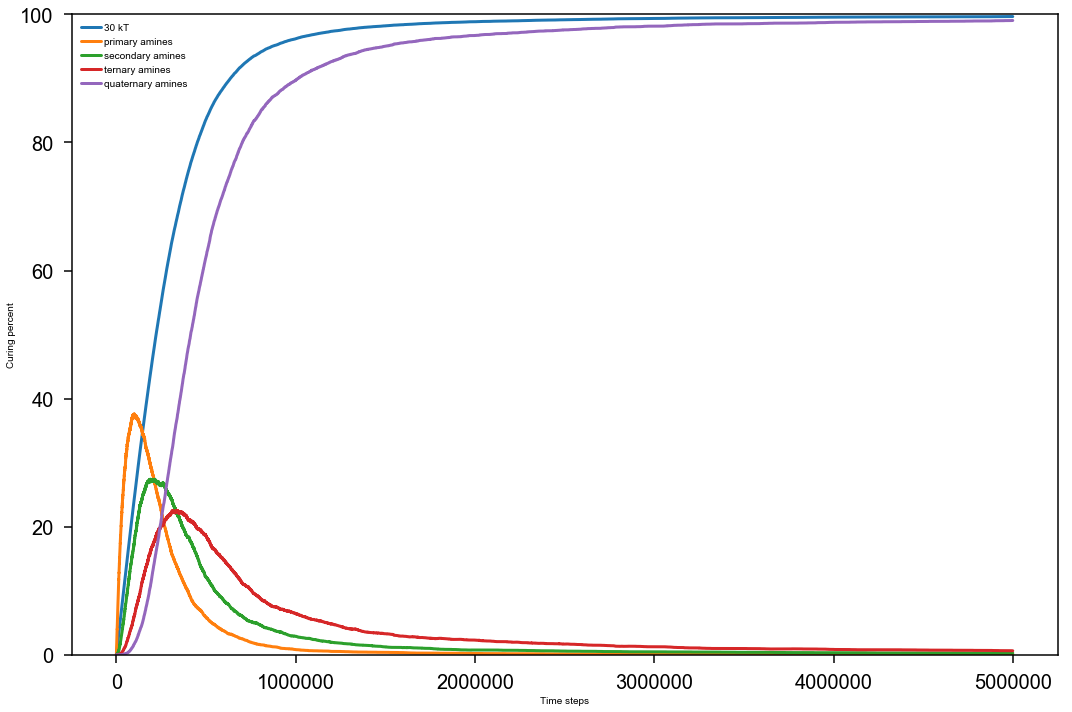

In [112]:
random.seed(12345)
kTs = [30]
activation_energy = 1
plot_bonding_degree(kTs, activation_energy,no_weights=True,show_all=True)

kT  30  bond_percent  99.665  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


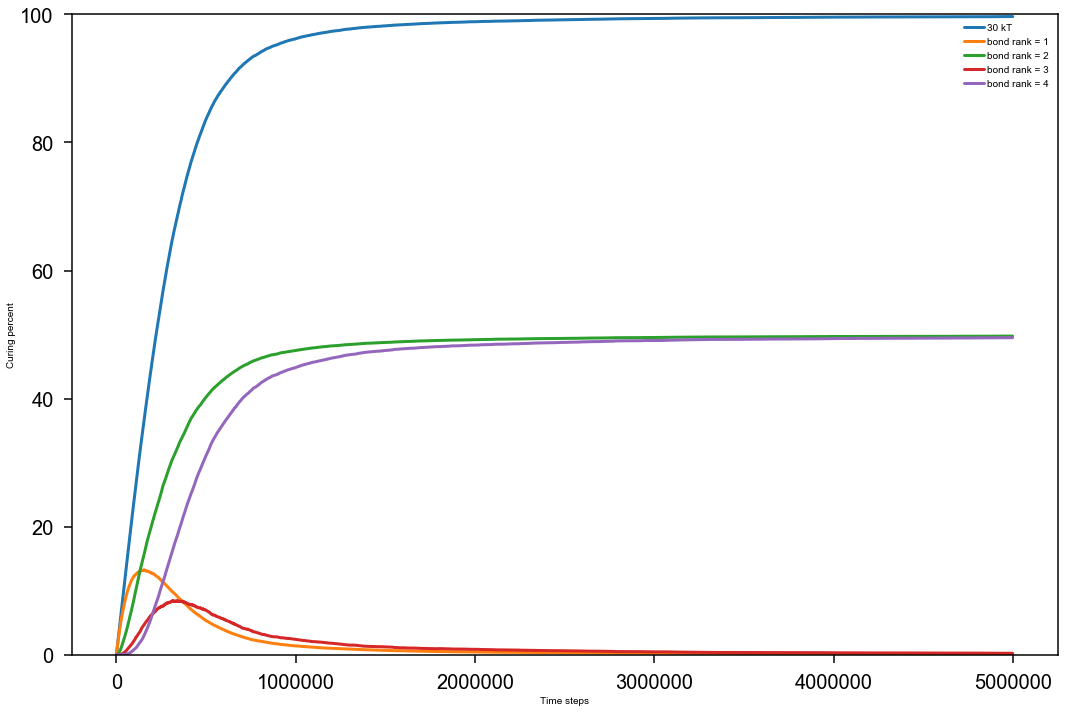

In [92]:
random.seed(12345)
kTs = [30]
activation_energy = 1
plot_bonding(kTs, activation_energy,no_weights=True,show_all=True)

### So, the system cures 100%
* As expected, the total cure percent reaches a 99.6 % by 5000000 steps .
* The bond rank 1 and 3 increases initially and reduces to zero.
* bond rank 2 and 4 reach 50 % eventually.


### But physically, the secondary bond formation has a lower probability. Below we try to use the weighting factor $w(\chi)$ and observe the curing rate at a medium temperature (1 kT).

kT  1  bond_percent  58.575  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


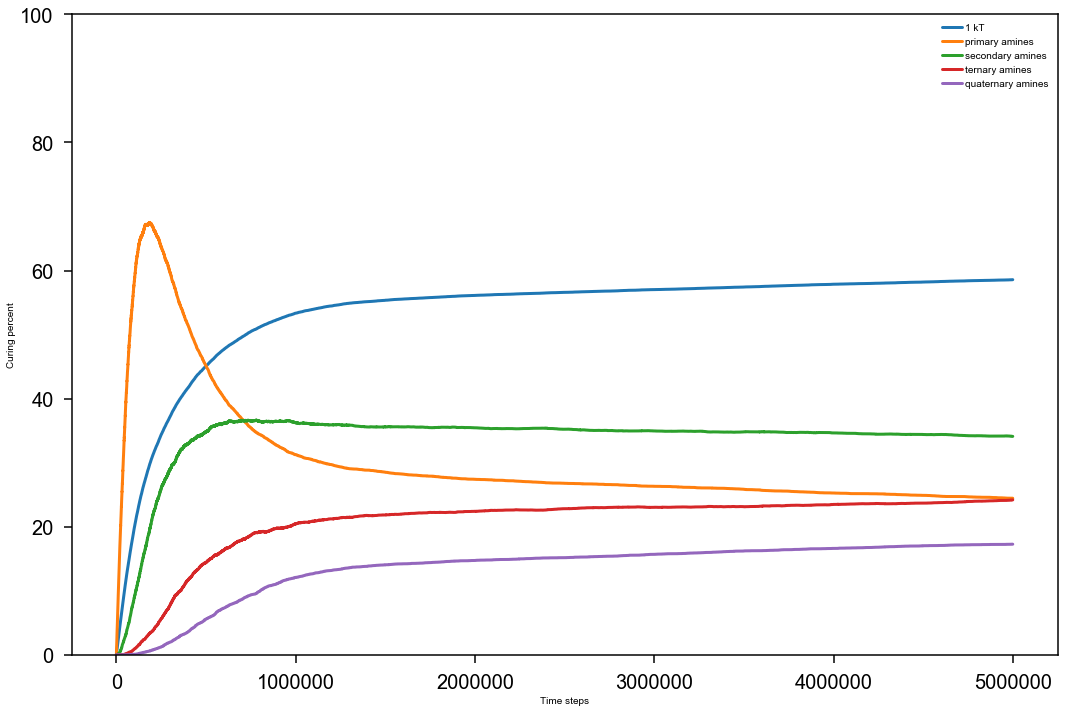

In [113]:
random.seed(12345)
kTs = [1]
activation_energy = 1
plot_bonding_degree(kTs, activation_energy,no_weights=False)

kT  1  bond_percent  58.575  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


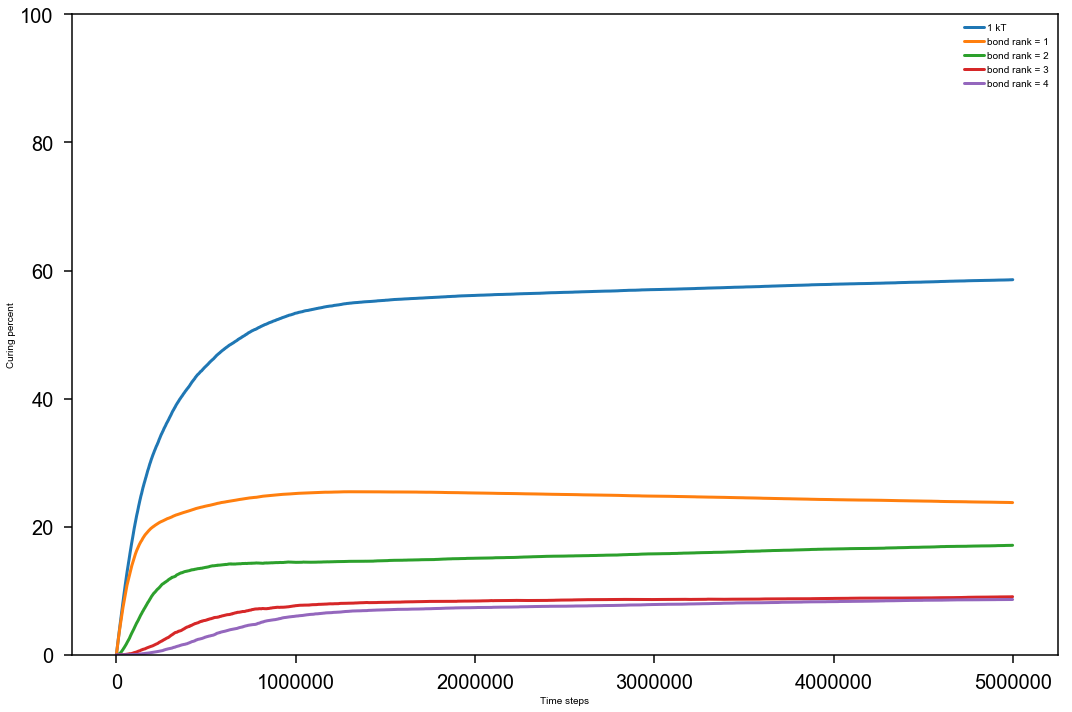

In [185]:
random.seed(12345)
kTs = [1]
activation_energy = 1
plot_bonding(kTs, activation_energy,no_weights=False)

### Cure percent has dropped significantly!
* When bond weights are assigned for secondary bonds, the total cure % reduced by ~35%. The total cure percent is 65%.
* The bond rank 1 and 3 shows decreasing trends like seen before.

### Does the curing increase with temperature?

kT  30  bond_percent  64.005  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


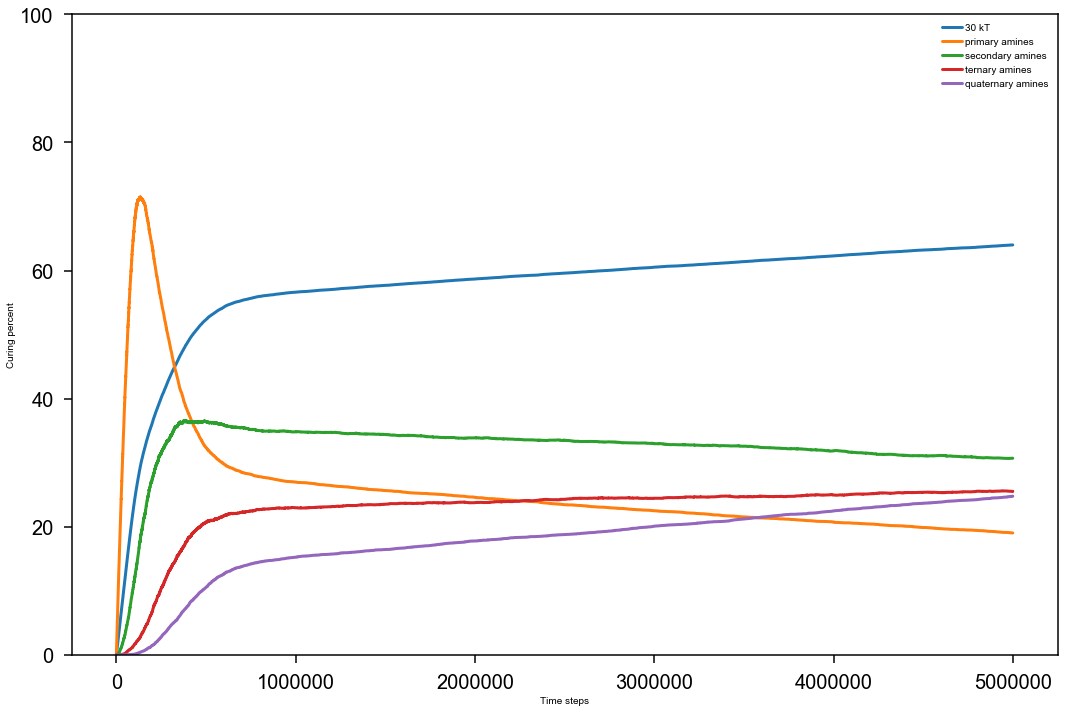

In [114]:
random.seed(12345)
kTs = [30]
activation_energy = 1
plot_bonding_degree(kTs, activation_energy,no_weights=False)

30000
possible_bonds:  40000.0
bond_percent  64.005  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


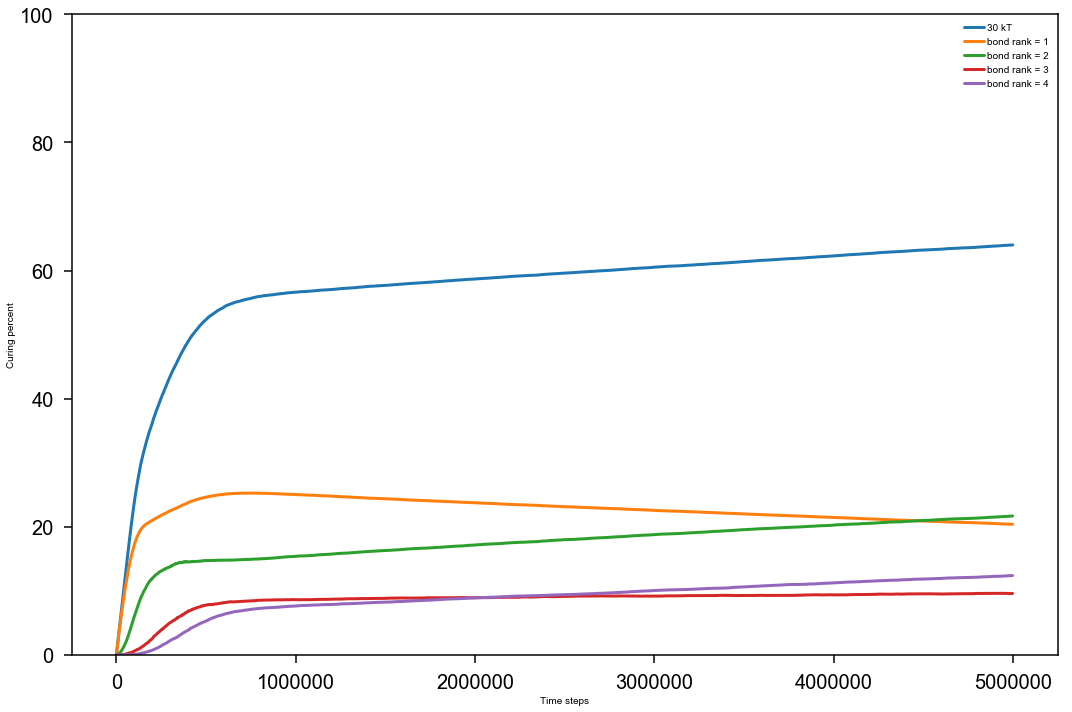

In [143]:
random.seed(12345)
kTs = [30]
activation_energy = 1
plot_bonding(kTs, activation_energy,no_weights=False)

### Yes, the system cures faster at 30 kT
* At 1 kT, the slope of the bond rank=2 is much lesser than 30 kT. 

### Lets compare side by side

kT  1  bond_percent  45.0775  time step  499999
kT  30  bond_percent  52.582499999999996  time step  499999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


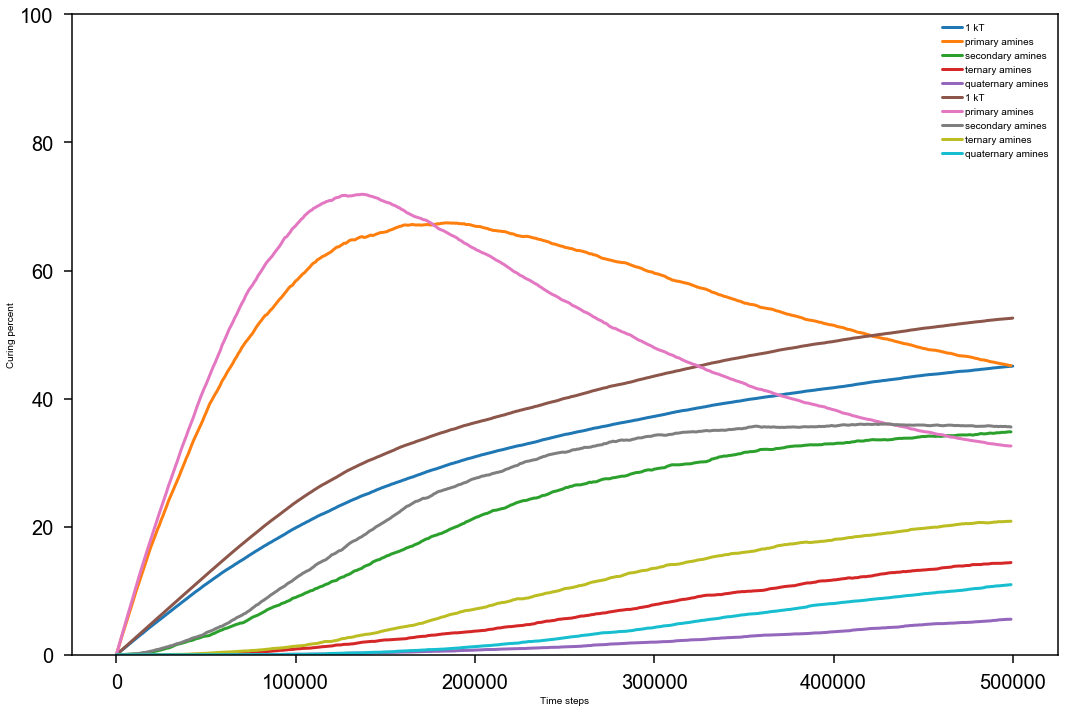

In [116]:
random.seed(12345)
kTs = [1,30]
activation_energy = 1
plot_bonding_degree(kTs, activation_energy,no_weights=False,time=500000,show_all=True)

kT  1  bond_percent  45.0775  time step  499999
kT  30  bond_percent  52.582499999999996  time step  499999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


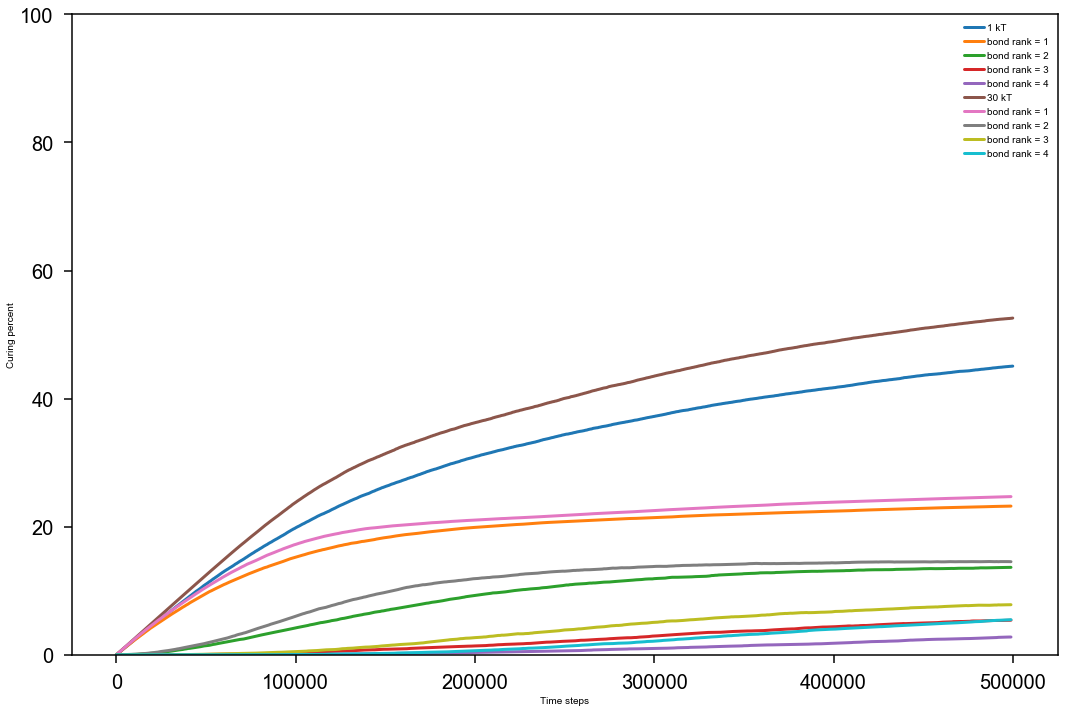

In [184]:
random.seed(12345)
kTs = [1,30]
activation_energy = 1
plot_bonding(kTs, activation_energy,no_weights=False,time=500000,show_all=True)

### Conclusion:

* The secondary bonds limits the curing when $w(\chi)$ is used.
* Higher temperatures yield higher curing rates
* But the curing has not completed.

## Question: How can we get to a 100% cure?

### How does reducing the weight factor affect the curing?

* First lets compare probability for $w(\chi)$ values 1 to 500.

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


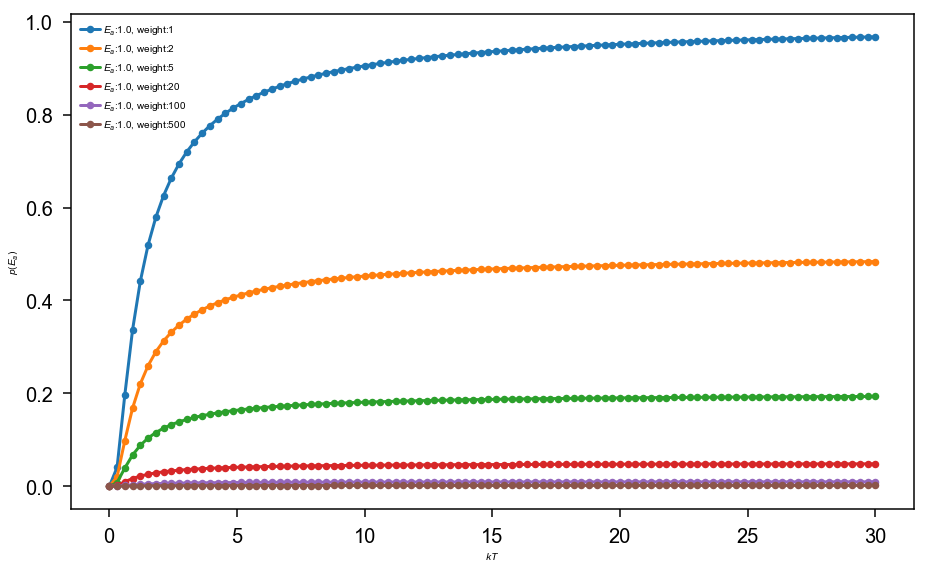

In [181]:
import numpy as np
kTs = np.linspace(0.01,30,100)
weights = [1,2,5,20,100,500]
delta_es = [1.0]#np.linspace(0.001,5,50)

plt.figure(figsize=(13,8))
for w in weights:
    for delta_e in delta_es:
        mb_stats = []
        for kT in kTs:
            mb_stat = np.exp(-delta_e / kT)
            mb_stats.append(mb_stat/w)
        label = '$E_a$:{}, weight:{}'.format(delta_e,w)
        plt.plot(kTs,mb_stats,marker='o',label=label)
plt.legend()
plt.xlabel('$kT$')
plt.ylabel('$p(E_a)$')
plt.tight_layout()
plt.show()

### Conclusion
* $w(\chi)$ value of 500 results in very low probabilities and may be too large to produce higher curing.

### Trying to confirm if a lower weighting factor ($w(\chi)$) will result in a higher curing.

kT  30  bond_percent  99.4475  time step  4999999
kT  30  bond_percent  88.5475  time step  4999999
kT  30  bond_percent  81.125  time step  4999999
kT  30  bond_percent  63.982499999999995  time step  4999999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


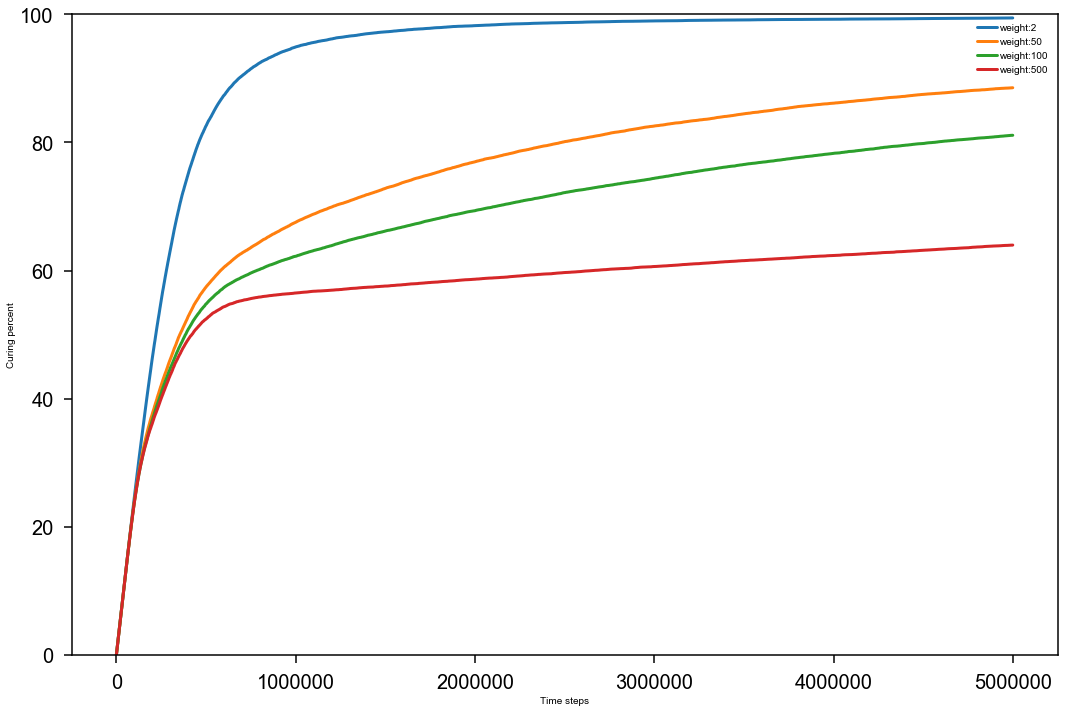

In [10]:
random.seed(12345)
kTs = [30]
activation_energy = 1
weights = [2,50,100,500]
plt.figure(figsize=(15,10))
for weight in weights:
    legend = 'weight:{}'.format(weight)
    plot_bonding(kTs, activation_energy,no_weights=False,show_all=False,weight=weight,show_figure=False,legend=legend)
plt.show()

### Yes, a lower weighting factor influences curing the most. It might be necessary to do so to get to a 100 % cure in a reasonable time. 5e6 time steps takes about 7 hours on r2

In [12]:
import epoxpy.abc_type_epoxy_simulation as es
import epoxpy.job as jb
import epoxpy.temperature_profile_builder as tpb
import os
import numpy as np
import shutil
import matplotlib
import signac


def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('out.log'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status


def run_epoxy_sim(sim_name, mix_time, mix_kt, temp_prof, bond, n_mul, shrink, legacy_bonding, ext_init_struct_path,
                  exclude_mixing_in_output, log_curing, curing_log_period, log_write, dcd_write, job, dt, density,
                  bond_period,activation_energy):

    fig_path = os.path.join(job.workspace(), 'temperature_profile.png')
    temp_temperature_profile = tpb.LinearTemperatureProfileBuilder(0)
    temp_temperature_profile.set_raw(temp_prof)
    temp_prof = temp_temperature_profile
    print('tempearture profile:{}'.format(temp_prof))
    fig = temp_prof.get_figure()
    fig.savefig(fig_path)
    in_path = os.path.join(job.workspace(), 'script_bckp.py')
    #shutil.copy(__file__, in_path)

    myEpoxySim = es.ABCTypeEpoxySimulation(sim_name, mix_time=mix_time, mix_kt=mix_kt, temp_prof=temp_prof, bond=bond,
                                           n_mul=n_mul, shrink=shrink, legacy_bonding=legacy_bonding,
                                           ext_init_struct_path=ext_init_struct_path,
                                           exclude_mixing_in_output=exclude_mixing_in_output, log_curing=log_curing,
                                           curing_log_period=curing_log_period, log_write=log_write,
                                           dcd_write=dcd_write, output_dir=job.workspace(), dt=dt, density=density,
                                           bond_period=bond_period, activation_energy=activation_energy)

    mySingleJobForEpoxy = jb.SingleJob(myEpoxySim)
    mySingleJobForEpoxy.execute()

    job.document['bond_percent'] = myEpoxySim.get_curing_percentage()
    log_path = os.path.join(job.workspace(), 'curing.log')
    np.savetxt(log_path, myEpoxySim.curing_log)

    curing_log = list(zip(*myEpoxySim.curing_log))
    fig = plt.figure()
    plt.xlabel('Time steps')
    plt.ylabel('Cure percent')
    plt.margins(x=0.1, y=0.1)
    plt.plot(curing_log[0], curing_log[1])
    plt.plot(curing_log[0], curing_log[1], 'or')
    fig_path = os.path.join(job.workspace(), 'curing_curve.png')
    fig.savefig(fig_path)

def init_job(state_point):
    project = signac.init_project('ABCTypeEpoxy', 'data/')
    job = project.open_job(state_point)
    job.init()
    job_status = get_status(job)
    print('job: {}, status:{}'.format(job, job_status))
    if job_status == 'init':
        fig_path = os.path.join(job.workspace(), 'temperature_profile.png')
        temp_temperature_profile = tpb.LinearTemperatureProfileBuilder(0)
        temp_temperature_profile.set_raw(job.sp.temp_prof)
        temp_prof = temp_temperature_profile
        print('tempearture profile:{}'.format(temp_prof))
        fig = temp_prof.get_figure()
        fig.savefig(fig_path)
        job_status = get_status(job)
        print('job: {}, status:{}'.format(job, job_status))
    
def run_simulation(state_point):
    project = signac.init_project('ABCTypeEpoxy', 'data/')
    job = project.open_job(state_point)
    job.init()
    job_status = get_status(job)
    print('job {}, status:{}'.format(job, job_status))
    if job_status == 'temperature-profile-created':
        run_epoxy_sim(job=job, **job.statepoint())
        job_status = get_status(job)
        print('job {}, status:{}'.format(job, job_status))

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Assembling the jobs

In [4]:
kTs = [0.1, 1, 2, 4, 6]
mixing_temperature = 2.0
mixing_time = 3e4
time_scale = 10

for kT in kTs:
    flat_temp_profile = tpb.LinearTemperatureProfileBuilder(initial_temperature=mixing_temperature,
                                                            initial_time=mixing_time)
    flat_temp_profile.add_state_point(50 * time_scale, kT)
    flat_temp_profile.add_state_point(450 * time_scale, kT)
    
    sp = {'sim_name': 'epoxy_curing_flat_temperature_profile_{}kT'.format(kT),
          'mix_time': mixing_time,
          'mix_kt': mixing_temperature,
          'temp_prof': flat_temp_profile.get_raw(),
          'bond': True,
          'n_mul': 1.0,
          'shrink': True,
          'legacy_bonding': False,
          'ext_init_struct_path': None,
          'exclude_mixing_in_output': False,
          'log_curing': True,
          'curing_log_period': 1e1,
          'log_write': 1e5,
          'dcd_write': 1e5,
          'bond_period': 1e1,
          'dt': 1e-2,
          'density': 1.0,
          'activation_energy':0.3}
    init_job(sp)

job: e4386c35adb2d2baa0fa34b0cb7c3dee, status:job-computed
job: 65ef6dfbc79b9c7c3be8b069a7414ed6, status:job-computed
job: 83a0b7823868f2a1af529da490923dea, status:job-computed
job: 4a7b9739a6293b7949d63c78e3429895, status:job-computed
job: 8ca7b4da0b8ba8e0e4d5b7a19e35cb15, status:job-computed


### Which curing profiles are we simulating?

job:69530a631d26dcb3a79d7c9a14abe317, final state points: 5030000.0 time step, 1 kT, status:job-computed
job:26f9cd888579d57bdc30a2f7f132c847, final state points: 5030000.0 time step, 4 kT, status:job-computed
job:669ed0c438b2ba51ad27b75bb399f267, final state points: 5030000.0 time step, 0.1 kT, status:job-computed
job:4bd061fc6f3226f52c74ccc9d61d5b21, final state points: 5030000.0 time step, 6 kT, status:job-computed
job:9c52e936a51f52f7a5295bdb1f2dfee1, final state points: 5030000.0 time step, 2 kT, status:job-computed
5


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


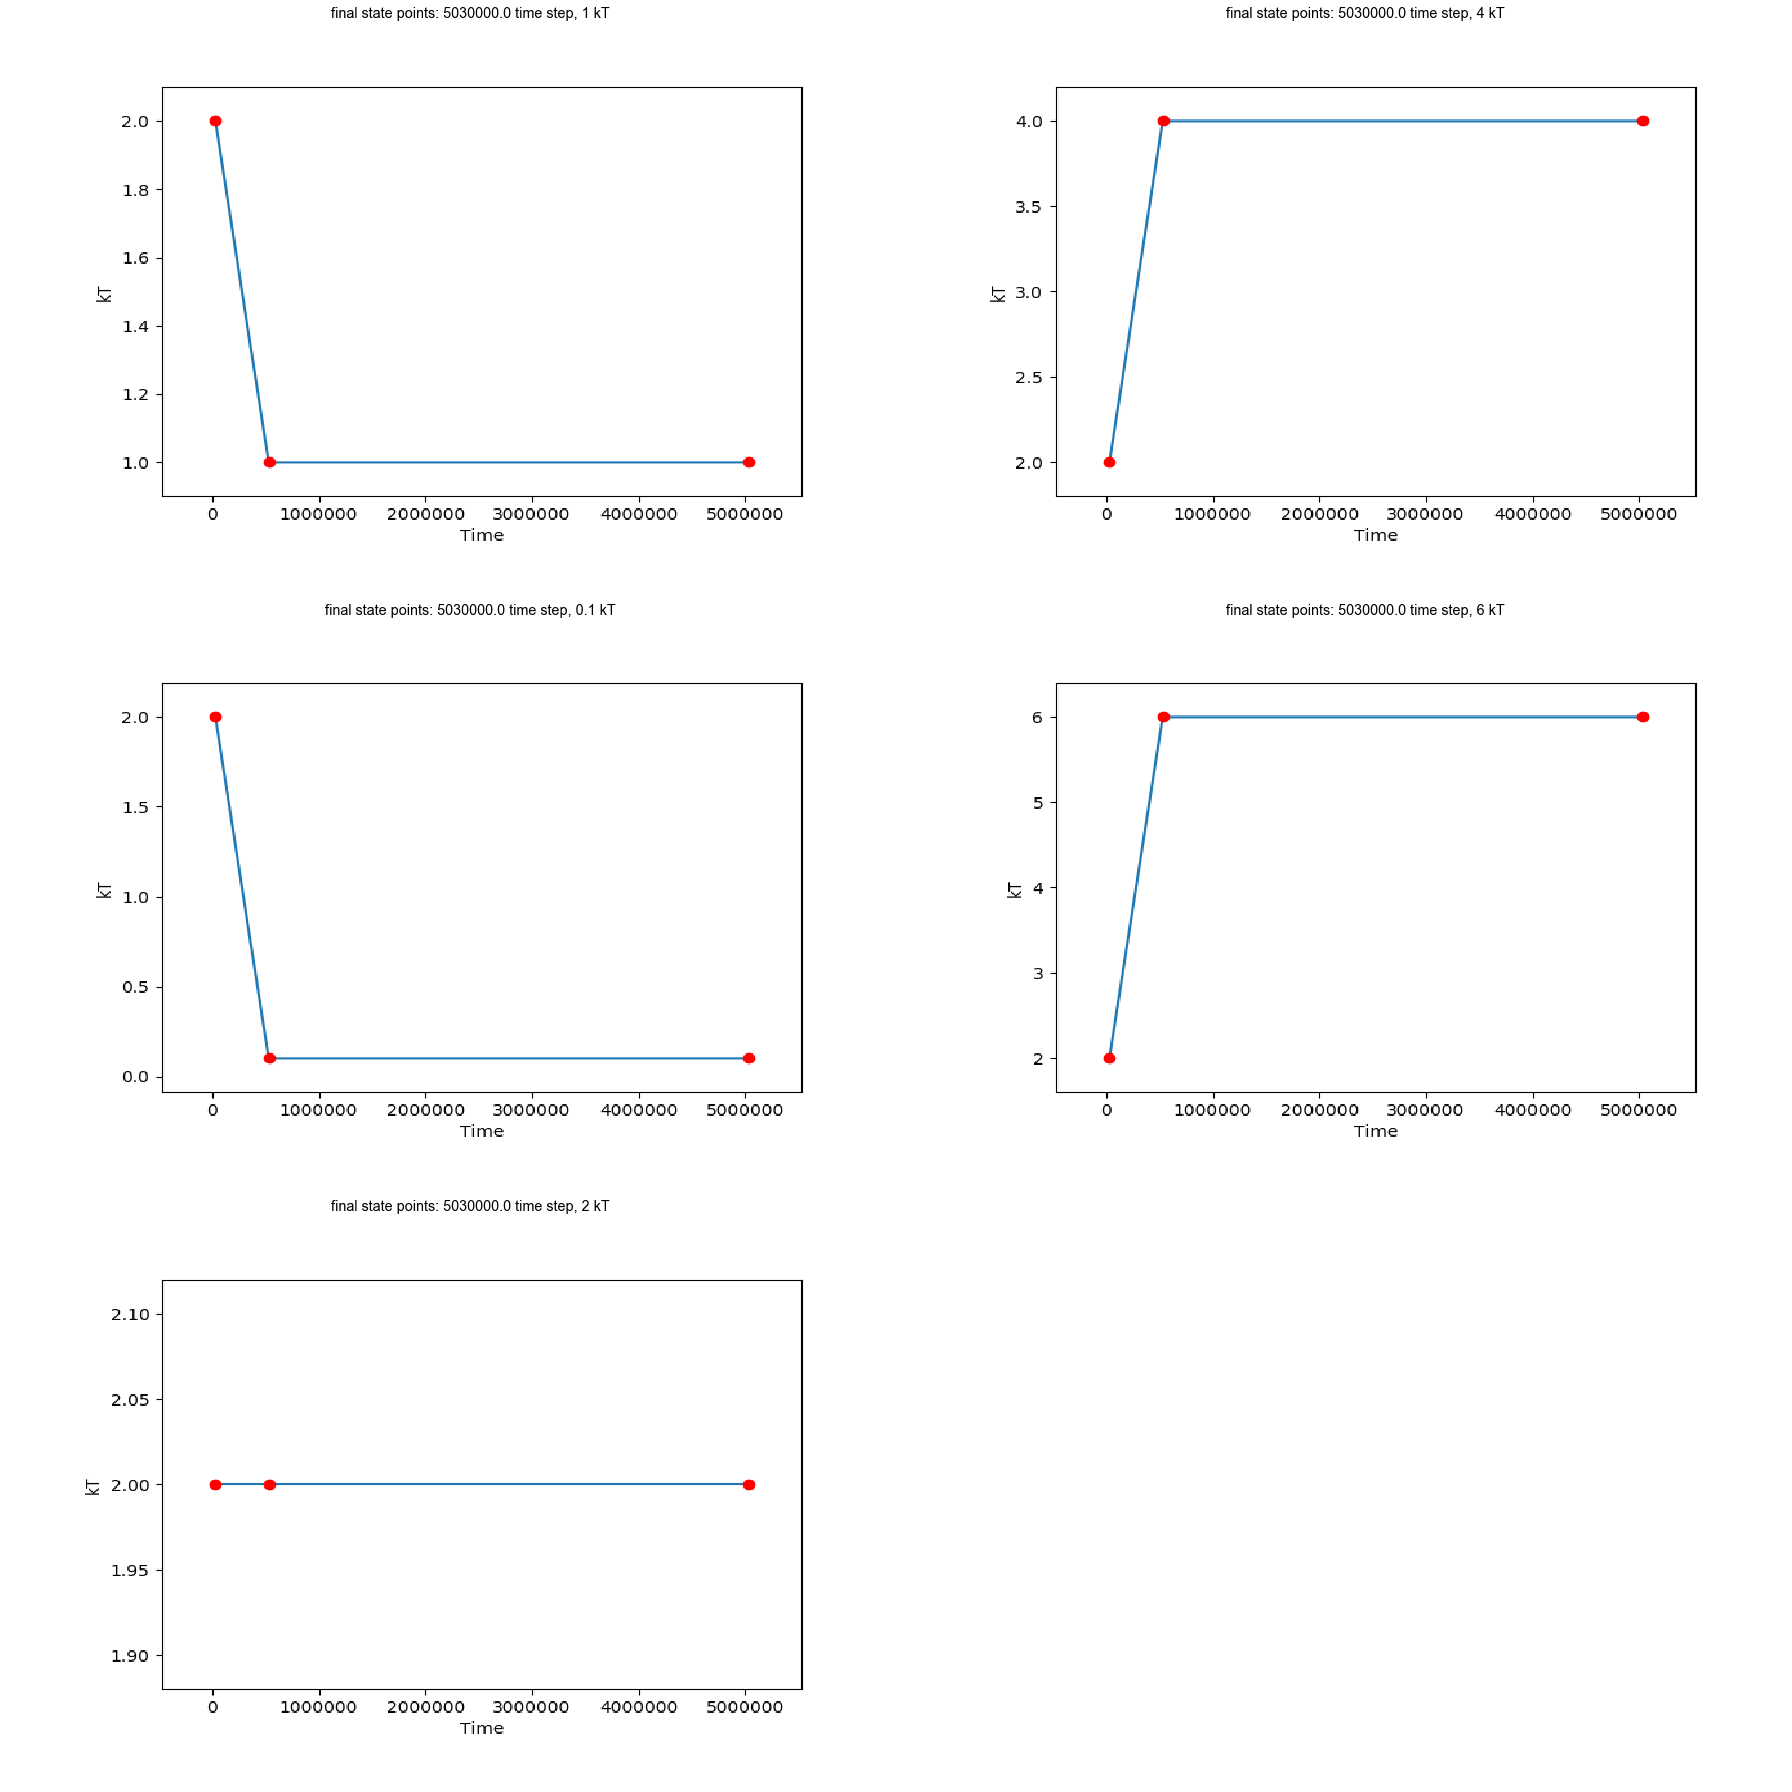

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

project = signac.init_project('ABCTypeEpoxy', 'data/')


jobs = project.find_jobs({'activation_energy':0.3})
for job in jobs:
    if job.sp.temp_prof[-1][0] == 5030000.0:
        job_status = get_status(job)
        print('job:{}, final state points: {} time step, {} kT, status:{}'.format(job, job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))


jobs = project.find_jobs({'activation_energy':0.3})
pltid=321
plt.figure(figsize=(25,25))
print(len(jobs))
for job in jobs:
    if job.sp.temp_prof[-1][0] == 5030000.0:
        ax = plt.subplot(pltid)
        img=mpimg.imread(job.fn('temperature_profile.png'))
        ax.imshow(img,interpolation='nearest', aspect='auto')
        ax.set_axis_off()
        ax.set_title('final state points: {} time step, {} kT'.format(job.sp.temp_prof[-1][0], job.sp.temp_prof[-1][1]))
        ax.autoscale(False)
        pltid+=1
plt.show()

### Run the jobs..

In [11]:
project = signac.init_project('ABCTypeEpoxy', 'data/')


jobs = project.find_jobs({'activation_energy':0.3,
                         'curing_log_period':1e1})
for job in jobs:
    if job.sp.temp_prof[-1][0] == 5030000.0:
        run_simulation(job.statepoint())

### What does the curing profiles look like?

final state points: 5030000.0 time step, 2 kT, status:job-computed
db96bcdd9808abbc238c6d9d0d10615e
final state points: 5030000.0 time step, 0.1 kT, status:job-computed
d65efbf3ecef83b1160f1e092c14a569
final state points: 5030000.0 time step, 1 kT, status:job-computed
f1780b841c0e0dd38e05bbae2fed3961
final state points: 5030000.0 time step, 6 kT, status:job-computed
e6ab7fa8d15d6ccd7366f78a77e766e2
final state points: 5030000.0 time step, 4 kT, status:job-computed
a694ae3e3b4388ccda5182a50f6f13a0


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


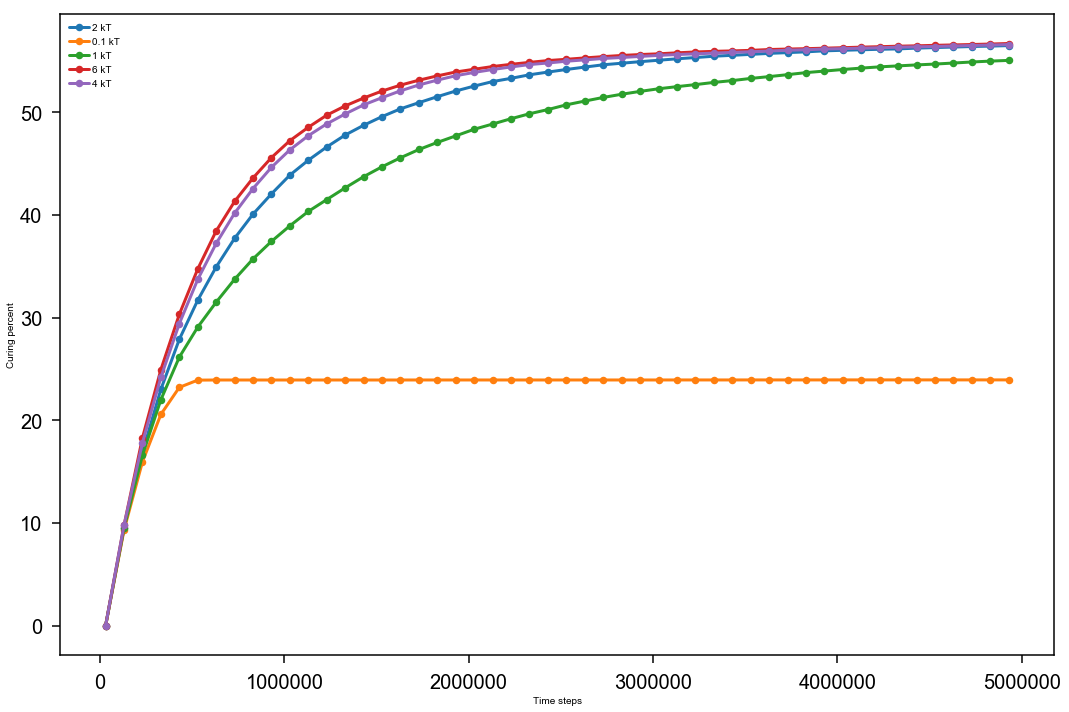

final state points: 5030000.0 time step, 2 kT, status:job-computed
db96bcdd9808abbc238c6d9d0d10615e
final state points: 5030000.0 time step, 0.1 kT, status:job-computed
d65efbf3ecef83b1160f1e092c14a569
final state points: 5030000.0 time step, 1 kT, status:job-computed
f1780b841c0e0dd38e05bbae2fed3961
final state points: 5030000.0 time step, 6 kT, status:job-computed
e6ab7fa8d15d6ccd7366f78a77e766e2
final state points: 5030000.0 time step, 4 kT, status:job-computed
a694ae3e3b4388ccda5182a50f6f13a0


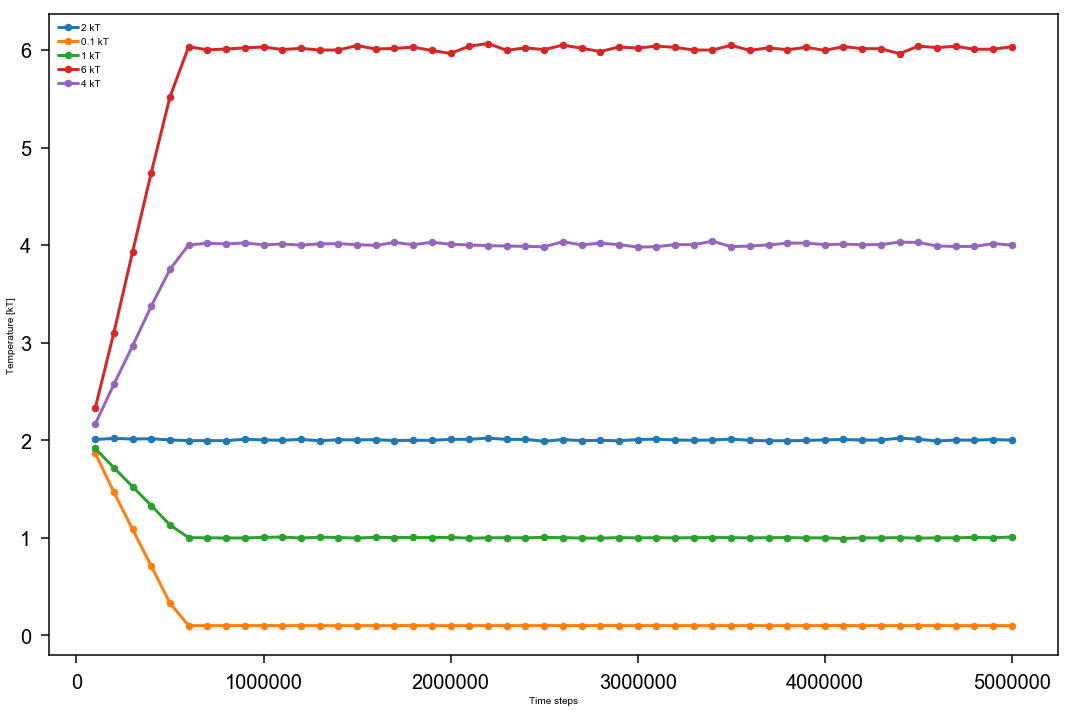

In [13]:
import signac
import matplotlib.pyplot as plt
%matplotlib inline

project = signac.init_project('ABCTypeEpoxy', '../data/')

jobs = project.find_jobs({'activation_energy':1})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job.sp.temp_prof[-1][0]== 5030000.0 and job.isfile('curing.log'):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('curing.log'))
        #print(data)
        legend = '{} kT'.format(job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,1], marker='o', label=legend)
plt.xlabel('Time steps')
plt.ylabel('Curing percent')
plt.legend()
plt.show()

jobs = project.find_jobs({'activation_energy':1})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job.sp.temp_prof[-1][0]== 5030000.0 and job.isfile('curing.log'):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('out.log'))
        #print(data)
        legend = '{} kT'.format(job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,6], marker='o', label=legend)
plt.xlabel('Time steps')
plt.ylabel('Temperature [kT]')
plt.legend()
plt.show()

### How long did it take to run the simulation?

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


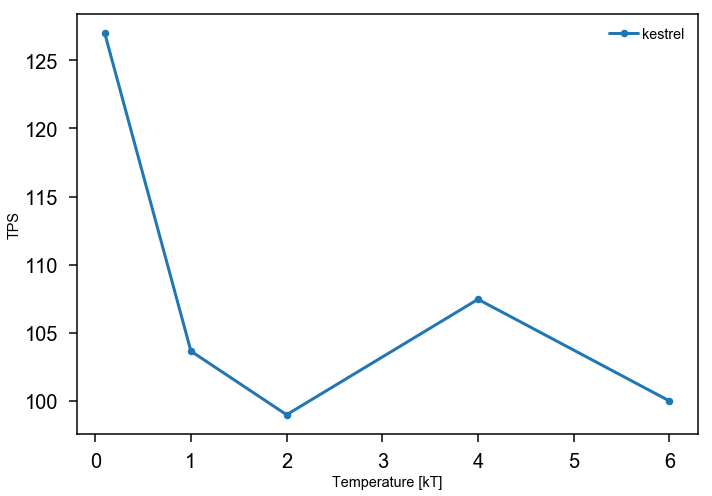

In [3]:
tps = [126.971,103.653,98.9849,107.459,100]
kTs = [0.1,1,2,4,6]
plt.figure(figsize=(10,7))
plt.xlabel('Temperature [kT]')
plt.ylabel('TPS')
plt.plot(kTs,tps,marker='o', label='kestrel')
plt.legend()
plt.show()

### Observations
* The distinct deviation in curing @ 0.1 kT is caused by the slow quenching to 0.1 kT from 2.0 kT. 

### Immediate quenching is shown below:

final state points: 9030001.0 time step, 4 kT, status:job-computed
956f1acc375c4c2cb7b8f0b644d99f8d
final state points: 9030001.0 time step, 0.1 kT, status:job-computed
b0291a0de9d05fbdcd555324639f9462
final state points: 9030001.0 time step, 1 kT, status:job-computed
aee688bdfe142a01969002c8cf1dae71
final state points: 9030001.0 time step, 6 kT, status:job-computed
21d8f1661a833c40ad3ddcb95f296005
final state points: 9030001.0 time step, 2 kT, status:job-computed
9e889aab2463152b3ec03bbe1ce25cce


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


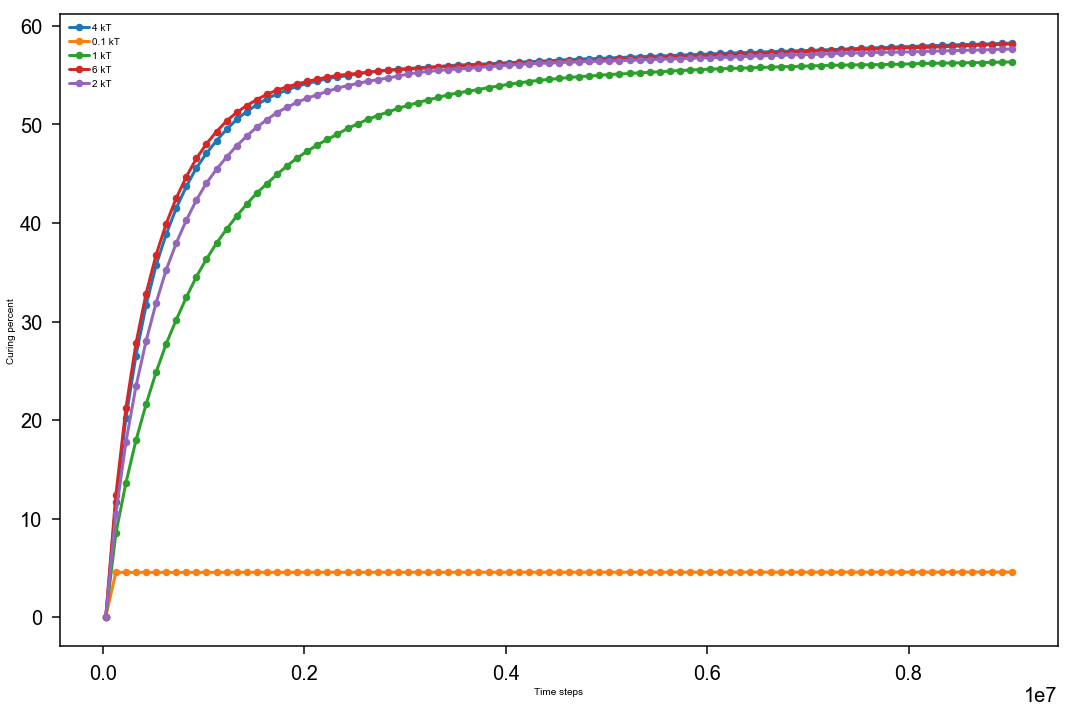

final state points: 9030001.0 time step, 4 kT, status:job-computed
956f1acc375c4c2cb7b8f0b644d99f8d
final state points: 9030001.0 time step, 0.1 kT, status:job-computed
b0291a0de9d05fbdcd555324639f9462
final state points: 9030001.0 time step, 1 kT, status:job-computed
aee688bdfe142a01969002c8cf1dae71
final state points: 9030001.0 time step, 6 kT, status:job-computed
21d8f1661a833c40ad3ddcb95f296005
final state points: 9030001.0 time step, 2 kT, status:job-computed
9e889aab2463152b3ec03bbe1ce25cce


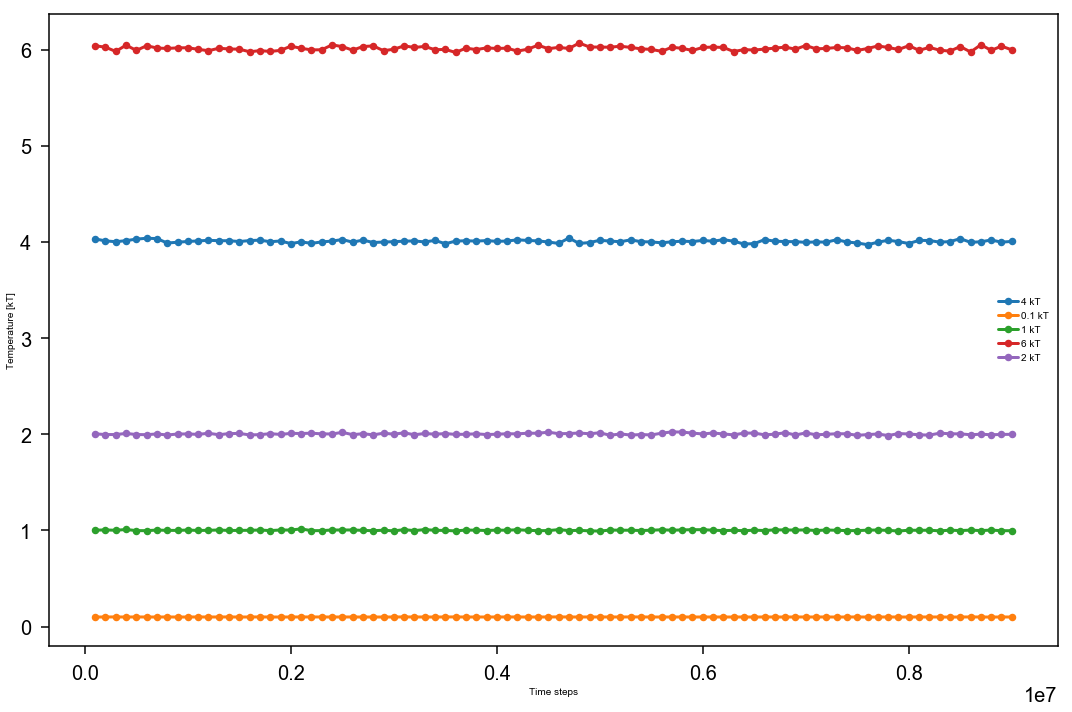

In [15]:
import signac
import matplotlib.pyplot as plt
%matplotlib inline

project = signac.init_project('ABCTypeEpoxy', '../data/')

jobs = project.find_jobs({'activation_energy':1})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job.sp.temp_prof[-1][0]== 9030001.0 and job.isfile('curing.log'):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('curing.log'))
        #print(data)
        legend = '{} kT'.format(job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,1], marker='o', label=legend)
plt.xlabel('Time steps')
plt.ylabel('Curing percent')
plt.legend()
plt.show()

jobs = project.find_jobs({'activation_energy':1})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job.sp.temp_prof[-1][0]== 9030001.0 and job.isfile('curing.log'):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('out.log'))
        #print(data)
        legend = '{} kT'.format(job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,6], marker='o', label=legend)
plt.xlabel('Time steps')
plt.ylabel('Temperature [kT]')
plt.legend()
plt.show()

### The total curing achieved using the MD system seems pretty close to the emulated system. Comparing the two systems side by side..

final state points: 9030001.0 time step, 1 kT, status:job-computed
aee688bdfe142a01969002c8cf1dae71
final state points: 9030001.0 time step, 6 kT, status:job-computed
21d8f1661a833c40ad3ddcb95f296005
possible_bonds:  40000.0
kT  1  bond_percent  61.38  time step  8999999.0
possible_bonds:  40000.0
kT  6  bond_percent  68.2375  time step  8999999.0


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


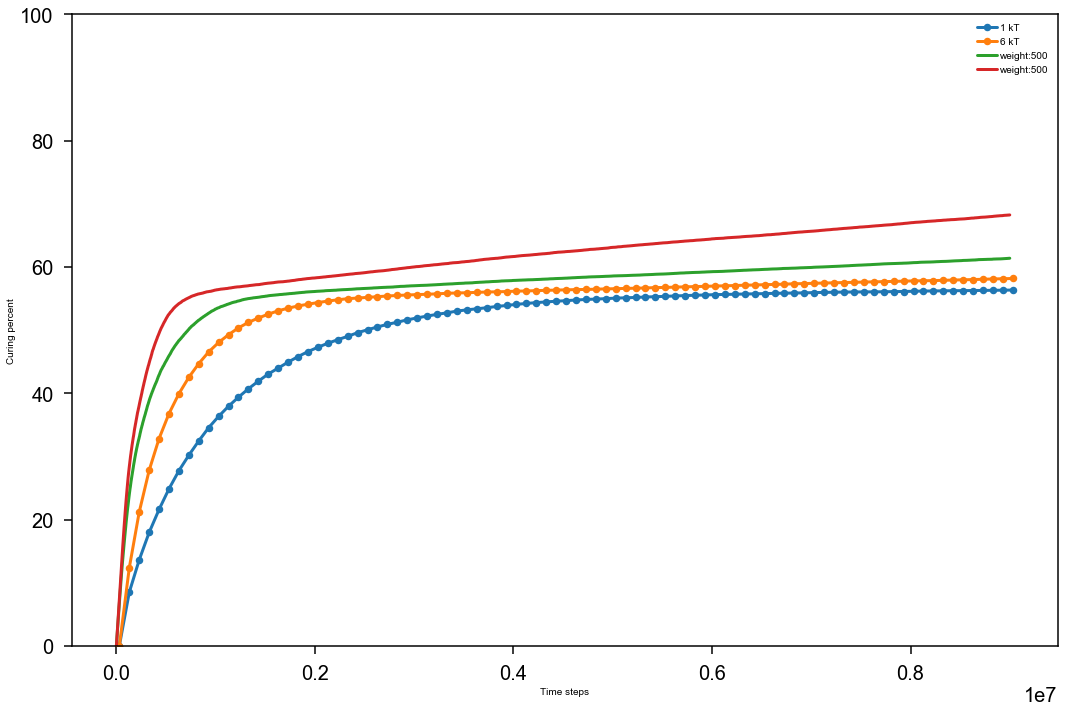

In [23]:
import signac
import matplotlib.pyplot as plt
%matplotlib inline

project = signac.init_project('ABCTypeEpoxy', '../data/')

jobs = project.find_jobs({'activation_energy':1})

plt.figure(figsize=(15,10))
for job in jobs:
    job_status = get_status(job)
    if job.sp.temp_prof[-1][0]== 9030001.0 and (job.sp.temp_prof[-1][1] == 6 or job.sp.temp_prof[-1][1] == 1):# and (job_status == 'job-computed'):
        print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
        print(job)
        data = np.genfromtxt(job.fn('curing.log'))
        #print(data)
        legend = '{} kT'.format(job.sp.temp_prof[-1][1])
        plt.plot(data[:,0],data[:,1], marker='o', label=legend)

random.seed(12345)
kTs = [1,6]
activation_energy = 1
weights = [500]
for weight in weights:
    legend = 'weight:{}'.format(weight)
    plot_bonding(kTs, activation_energy,no_weights=False,time=9e6,show_all=False,weight=weight,show_figure=False,legend=legend)


plt.xlabel('Time steps')
plt.ylabel('Curing percent')
plt.legend()
plt.show()

### Another observation is that the total cure % does not increase appreciably with increasing temperature. This raises the questions:

* Is the weighting factor of 500 correct for this system?
* The weighting factor is trying to capture the shape of the molecule limiting secondary bond formation. Is this dependent on temperature? If yes, should the weighting factor be within the exponent where it scales the activation energy ($E_a$)?

#### Below we explore the difference between scheme2 (where $w(\chi)$ is a constant value of 1),  scheme1 (where $w(\chi)$ is outside the exponent) and scheme2 (where $w(\chi)$ is inside the exponent)

kT  300  bond_percent  83.63000000000001  time step  499999
kT  300  bond_percent  52.5025  time step  499999
kT  300  bond_percent  76.63250000000001  time step  499999


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


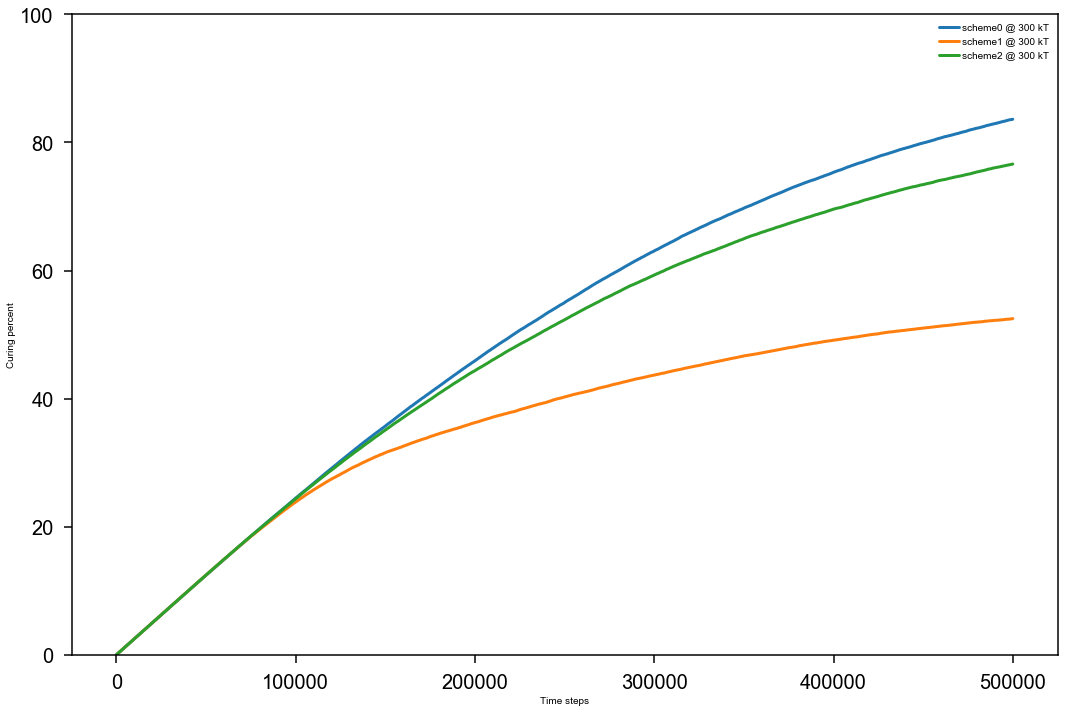

In [38]:
random.seed(12345)
kTs = [300]
plt.figure(figsize=(15,10))
activation_energy = 1
plot_bonding(kTs, activation_energy,no_weights=True,time=500000,legend='scheme0 @ 300 kT',show_all=False,weighting_scheme2=False,show_figure=False)
plot_bonding(kTs, activation_energy,no_weights=False,time=500000,legend='scheme1 @ 300 kT',show_all=False,weighting_scheme2=False,show_figure=False)
plot_bonding(kTs, activation_energy,no_weights=False,time=500000,legend='scheme2 @ 300 kT',show_all=False,weighting_scheme2=True,show_figure=False)